Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Loading Dataset

In [2]:
df = pd.read_csv('../data/books.csv')

In [3]:
df.shape

(6810, 12)

In [4]:
df.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


Let's look at some statistical measures

In [5]:
df.describe()

,isbn13,published_year,average_rating,num_pages,ratings_count
count,6.810000e+03,6804.000000,6767.000000,6767.000000,6.767000e+03
mean,9.780677e+12,1998.630364,3.933284,348.181026,2.106910e+04
std,6.068911e+08,10.484257,0.331352,242.376783,1.376207e+05
min,9.780002e+12,1853.000000,0.000000,0.000000,0.000000e+00
25%,9.780330e+12,1996.000000,3.770000,208.000000,1.590000e+02
50%,9.780553e+12,2002.000000,3.960000,304.000000,1.018000e+03
75%,9.780810e+12,2005.000000,4.130000,420.000000,5.992500e+03
max,9.789042e+12,2019.000000,5.000000,3342.000000,5.629932e+06


Duplicated books

In [28]:
print('number of duplicated books:',df.duplicated().sum())

number of duplicated books: 0


Let's now look at missing values

In [7]:
for col in df.columns:
    print("number of missing values for the col",col,"is",df[col].isnull().sum())

number of missing values for the col isbn13 is 0
number of missing values for the col isbn10 is 0
number of missing values for the col title is 0
number of missing values for the col subtitle is 4429
number of missing values for the col authors is 72
number of missing values for the col categories is 99
number of missing values for the col thumbnail is 329
number of missing values for the col description is 262
number of missing values for the col published_year is 6
number of missing values for the col average_rating is 43
number of missing values for the col num_pages is 43
number of missing values for the col ratings_count is 43


We have the most missing values in subtitles, and 262 in description col, which is our most important column.

In [8]:
df.nunique()

isbn13            6810
isbn10            6810
title             6398
subtitle          2009
authors           3780
categories         567
thumbnail         6481
description       6474
published_year      94
average_rating     200
num_pages          915
ratings_count     3881
dtype: int64

we will use a heatmap to find patterns in missing values

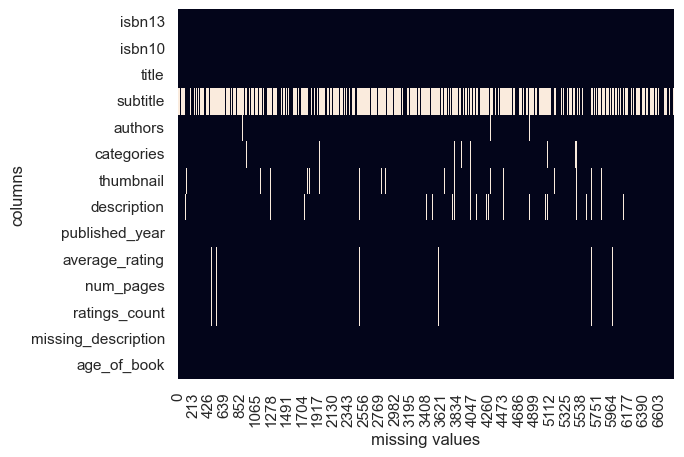

In [30]:
ax = plt.axes()
sns.heatmap(df.isna().transpose(),cbar=False,ax=ax)

plt.ylabel('columns')
plt.xlabel('missing values')

plt.savefig('../plots/cols_vs_missing_vals.png',dpi=300)
plt.show()

Conclusions:
* subtitle has the most missing values
* we can see a pattern regarding the last 3 columns, if an observation has a missing value in one of them, the other two are also missing.

We need to see if there is any bias regarding the missing descriptions (which is the most important feature for our recommener system), (maybe they are newer, their rating or other features)
* We can construct a correlation matrix to find out

In [10]:
import numpy as np

df['missing_description'] = np.where(df['description'].isna(),1,0)
df['age_of_book'] = 2025 - df['published_year']

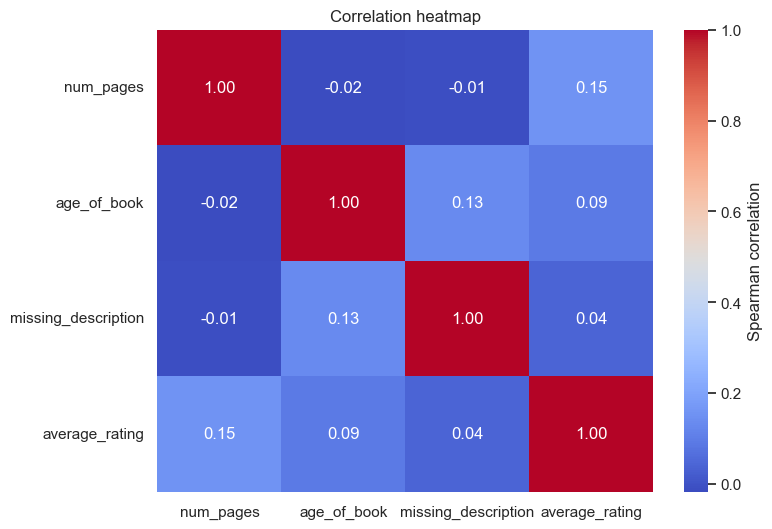

In [29]:
cols = ['num_pages','age_of_book','missing_description','average_rating']
correlation_matrix = df[cols].corr(method = "spearman")

sns.set_theme(style="white")
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm",
                      cbar_kws={"label": "Spearman correlation"})
heatmap.set_title("Correlation heatmap")

plt.savefig('../plots/corr_matrix.png',dpi=300)
plt.show()

Conclusion: missing description have weak correlation with other variables. It's safe to drop books with missing values.
* Dropping missing values from a column that has a strong correlation with other columns can introduce bias in our recommender system.

Let's look at how many missing rows we have

In [12]:
df_missing = df[ (df['description'].isnull())
   | (df['num_pages'].isnull())
   | (df['average_rating'].isnull())
   | (df['published_year'].isnull())]

df_missing.shape

(303, 14)

We have 303 rows, we can get rid of them

In [13]:
df1 = df[ ~(df['description'].isnull())
   & ~(df['num_pages'].isnull())
   & ~(df['average_rating'].isnull())
   & ~(df['published_year'].isnull())]
df1.shape

(6507, 14)

Let's take a look at out categories column

In [14]:
df1['categories'].nunique()

531

We have around 531 unique categories, we will narrow them down to a few meaningful ones later

In [15]:
df1['categories'].isnull().sum()

np.int64(33)

And 33 missing values

Let's look at its distribution, and look at the most frequent categories

In [16]:
df1['categories'].value_counts().reset_index()[:10]

,categories,count
0,Fiction,2523
1,Juvenile Fiction,534
2,Biography & Autobiography,391
3,History,258
4,Literary Criticism,164
5,Philosophy,154
6,Comics & Graphic Novels,152
7,Religion,136
8,Drama,126
9,Juvenile Nonfiction,114


We have an unbalanced distribution of the categories with fiction the most frequent.

Refining description column

In [17]:
df1['words_in_description'] = df1['description'].str.split().str.len()

C:\Users\ghass\AppData\Local\Temp\ipykernel_16572\2611664758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['words_in_description'] = df1['description'].str.split().str.len()


In [18]:
df1['words_in_description'].sort_values(ascending=False)

4144    920
4091    621
6700    619
1848    575
5600    512
       ... 
5243      1
5599      1
5135      1
6         1
6721      1
Name: words_in_description, Length: 6507, dtype: int64

In [19]:
df1['words_in_description'].describe()

count    6507.000000
mean       66.325803
std        66.120291
min         1.000000
25%        27.000000
50%        40.000000
75%        82.000000
max       920.000000
Name: words_in_description, dtype: float64

In [20]:
df1.loc[df1['words_in_description'].between(1,4),"description"]

6                                           Donation.
11                                     Fantasy-roman.
748              Includes bibliographical references.
770                             Bound For Oregon (PB)
775                                No Marketing Blurb
812                                No Marketing Blurb
857                          First published in 1813.
944                         Edited by Maurice Hindle.
953                        DEFOE/ROBINSON CRUSOE (BC)
954                             Edited by John Carey.
962                         ALLEN/GETTING THINGS DONE
1054                            GILBERT/EAT PRAY LOVE
1056    "Graham Greene centennial, 1904-2004"--Cover.
1060                   STEINBECK/GRAPES OF WRATH (BC)
1346                                   Fantasy-roman.
1546                                      Winter 2003
1610                                      Winter 1999
1813                             National bestseller.
1981                        

Choosing an interval considering number of words in the description col (so that the description becomes meaningful)

In [21]:
df2 = df1[(df1['words_in_description'] >= 25)& (df1['words_in_description'] <=100)]
df2.shape

(3825, 15)

we create a new field title&subtitle to deal with the missing rows in subtitle field (we will pair them if they exist,else we jute write the title)

In [22]:
df2['title_and_subtitle'] = (
    np.where(df2['subtitle'].isna(),df2['title'],
             df2[['title','subtitle']].astype(str).agg(": ".join,axis=1))
)

C:\Users\ghass\AppData\Local\Temp\ipykernel_16572\4052381454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['title_and_subtitle'] = (


In [23]:
df2.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description,title_and_subtitle
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57,Rage of angels
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45,The Four Loves
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75,The Problem of Pain
7,9780006380832,0006380832,Empires of the Monsoon,A History of the Indian Ocean and Its Invaders,Richard Hall,"Africa, East",http://books.google.com/books/content?id=MuPEQ...,Until Vasco da Gama discovered the sea-route t...,1998.0,4.41,608.0,65.0,0,27.0,80,Empires of the Monsoon: A History of the India...
9,9780006472612,0006472613,Master of the Game,NaN,Sidney Sheldon,Adventure stories,http://books.google.com/books/content?id=TkTYp...,Kate Blackwell is an enigma and one of the mos...,1982.0,4.11,489.0,43540.0,0,43.0,30,Master of the Game


We need now to create a new column which tags each unique description.
* this is useful to get the metadata of the book from it's recommended description so that we can show it to the user

In [24]:
df2['tagged_description'] = df2[['isbn13','description']].astype(str).agg(" ".join,axis=1)

C:\Users\ghass\AppData\Local\Temp\ipykernel_16572\3991898117.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['tagged_description'] = df2[['isbn13','description']].astype(str).agg(" ".join,axis=1)


In [25]:
df2.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description,title_and_subtitle,tagged_description
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45,The Four Loves,9780006280897 Lewis' work on the nature of lov...
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."
7,9780006380832,0006380832,Empires of the Monsoon,A History of the Indian Ocean and Its Invaders,Richard Hall,"Africa, East",http://books.google.com/books/content?id=MuPEQ...,Until Vasco da Gama discovered the sea-route t...,1998.0,4.41,608.0,65.0,0,27.0,80,Empires of the Monsoon: A History of the India...,9780006380832 Until Vasco da Gama discovered t...
9,9780006472612,0006472613,Master of the Game,NaN,Sidney Sheldon,Adventure stories,http://books.google.com/books/content?id=TkTYp...,Kate Blackwell is an enigma and one of the mos...,1982.0,4.11,489.0,43540.0,0,43.0,30,Master of the Game,9780006472612 Kate Blackwell is an enigma and ...


Now that the dataset is ready, we can drop columns we don't need and save it.

In [26]:
df2.drop([
    "subtitle",
    "missing_description",
    "age_of_book",
    "words_in_description"
],axis=1)

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description
3,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
4,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...
5,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."
7,9780006380832,0006380832,Empires of the Monsoon,Richard Hall,"Africa, East",http://books.google.com/books/content?id=MuPEQ...,Until Vasco da Gama discovered the sea-route t...,1998.0,4.41,608.0,65.0,Empires of the Monsoon: A History of the India...,9780006380832 Until Vasco da Gama discovered t...
9,9780006472612,0006472613,Master of the Game,Sidney Sheldon,Adventure stories,http://books.google.com/books/content?id=TkTYp...,Kate Blackwell is an enigma and one of the mos...,1982.0,4.11,489.0,43540.0,Master of the Game,9780006472612 Kate Blackwell is an enigma and ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,9784770028969,4770028962,Coin Locker Babies,村上龍,Fiction,http://books.google.com/books/content?id=87DJw...,Rescued from the lockers in which they were le...,2002.0,3.75,393.0,5560.0,Coin Locker Babies,9784770028969 Rescued from the lockers in whic...
6799,9788122200850,8122200850,"Cry, the Peacock",Anita Desai,Fiction,http://books.google.com/books/content?id=_QKwV...,This book is the story of a young girl obsesse...,1980.0,3.22,218.0,134.0,"Cry, the Peacock",9788122200850 This book is the story of a youn...
6800,9788125026600,8125026606,Nietzsche For Beginners,Marc Sautet,NaN,http://books.google.com/books/content?id=fPIv8...,Not only does Nietzsche for Beginners delve in...,2004.0,3.26,192.0,21.0,Nietzsche For Beginners,9788125026600 Not only does Nietzsche for Begi...
6801,9788171565641,8171565646,Aspects of the Novel,E. M. Forster,English fiction,http://books.google.com/books/content?id=qWU9P...,"Forster's lively, informed originality and wit...",2004.0,3.83,141.0,10.0,Aspects of the Novel,"9788171565641 Forster's lively, informed origi..."


In [27]:
df2.to_csv('../data/cleaned_data_v2.csv',index=False)